# Step 1: Download dataset from Kaggle
Note: A kaggle API token is required to download from kaggle

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download planttraits2024

100% 3.17G/3.17G [00:40<00:00, 87.2MB/s]
100% 3.17G/3.17G [00:40<00:00, 83.5MB/s]


In [ ]:
!unzip planttraits2024.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/196423534.jpeg  
  inflating: train_images/196423707.jpeg  
  inflating: train_images/196423993.jpeg  
  inflating: train_images/196424200.jpeg  
  inflating: train_images/196424210.jpeg  
  inflating: train_images/196424213.jpeg  
  inflating: train_images/196424291.jpeg  
  inflating: train_images/196424430.jpeg  
  inflating: train_images/196424593.jpeg  
  inflating: train_images/196424666.jpeg  
  inflating: train_images/196424802.jpeg  
  inflating: train_images/196424812.jpeg  
  inflating: train_images/196424938.jpeg  
  inflating: train_images/196425178.jpeg  
  inflating: train_images/196425491.jpeg  
  inflating: train_images/196425781.jpeg  
  inflating: train_images/196426308.jpeg  
  inflating: train_images/196426979.jpeg  
  inflating: train_images/196427019.jpeg  
  inflating: train_images/196427071.jpeg  
  inflating: train_images/196427085.jpeg  
  inflating: train_images/196427243.jpeg  
  i

In [ ]:
!pip install timm
!pip install torchmetrics
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as imageio
import albumentations as A

from albumentations.pytorch import ToTensorV2
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader
from torcheval.metrics import R2Score
from torch import nn
from timeit import default_timer as timer
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import timm
import glob
import torchmetrics
import torchvision
import time
import psutil
import os


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

tqdm.pandas()

Using cpu for inference


# Step 2: Understanding the dataset

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
train_df['image'] = train_df['id'].progress_apply(lambda id: open(f'./train_images/{id}.jpeg', 'rb').read())
test_df['image'] = test_df['id'].progress_apply(lambda id: open(f'./test_images/{id}.jpeg', 'rb').read())

  0%|          | 0/55489 [00:00<?, ?it/s]

  0%|          | 0/6545 [00:00<?, ?it/s]

In [ ]:
train_df

id  WORLDCLIM_BIO1_annual_mean_temperature  \
0      192027691                               12.235703   
1      195542235                               17.270555   
2      196639184                               14.254504   
3      195728812                               18.680834   
4      195251545                                0.673204   
...          ...                                     ...   
55484  190558785                               19.472172   
55485  194523231                               13.724150   
55486  195888987                               14.741204   
55487  135487319                               16.094763   
55488  146608105                               24.559971   

       WORLDCLIM_BIO12_annual_precipitation  \
0                                374.466675   
1                                 90.239998   
2                                902.071411   
3                               1473.933350   
4                                530.088867   
...                                     ...   
55484                            244.795914   
55485                           1450.000000   
55486                            581.866638   
55487                           1180.838135   
55488                           1748.857178   

       WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month  \
0                                              62.524445                       
1                                              10.351111                       
2                                              49.642857                       
3                                             163.100006                       
4                                              50.857777                       
...                                                  ...                       
55484                                          39.127552                       
55485                                         162.260208                       
55486                                         109.231110                       
55487                                          80.176193                       
55488                                         272.821442                       

       WORLDCLIM_BIO15_precipitation_seasonality  \
0                                      72.256844   
1                                      38.220940   
2                                      17.873655   
3                                      45.009758   
4                                      38.230709   
...                                          ...   
55484                                  67.074493   
55485                                  43.139324   
55486                                  89.272148   
55487                                  22.909716   
55488                                  51.363777   

       WORLDCLIM_BIO4_temperature_seasonality  \
0                                  773.592041   
1                                  859.193298   
2                                  387.977753   
3                                  381.053986   
4                                 1323.526855   
...                                       ...   
55484                              472.710358   
55485                              652.716858   
55486                              507.273010   
55487                              342.184021   
55488                               73.158348   

       WORLDCLIM_BIO7_temperature_annual_range  SOIL_bdod_0.5cm_mean_0.01_deg  \
0                                    33.277779                            125   
1                                    40.009777                            124   
2                                    22.807142                            107   
3                                    20.436666                            120   
4                                    45.891998                             91   
...                                        ...                     

Notice that our output columns in the above pandas frame is X4_mean, X11_mean, X18_mean, X50_mean, X26_mean, X3112_mean. The explaination is given below in this csv

In [ ]:
traits_df = pd.read_csv('target_name_meta.tsv', delimiter='\t')
traits_df

trait_ID                                        trait_name 
0       X4  Stem specific density (SSD) or wood density (s...
1      X11  Leaf area per leaf dry mass (specific leaf are...
2      X18                                      Plant height 
3      X26                                     Seed dry mass 
4      X50           Leaf nitrogen (N) content per leaf area 
5    X3112  Leaf area (in case of compound leaves: leaf, u...

In [ ]:
target_cols = np.array(traits_df['trait_ID']+'_mean')

We should also observe the distribution of the output labels

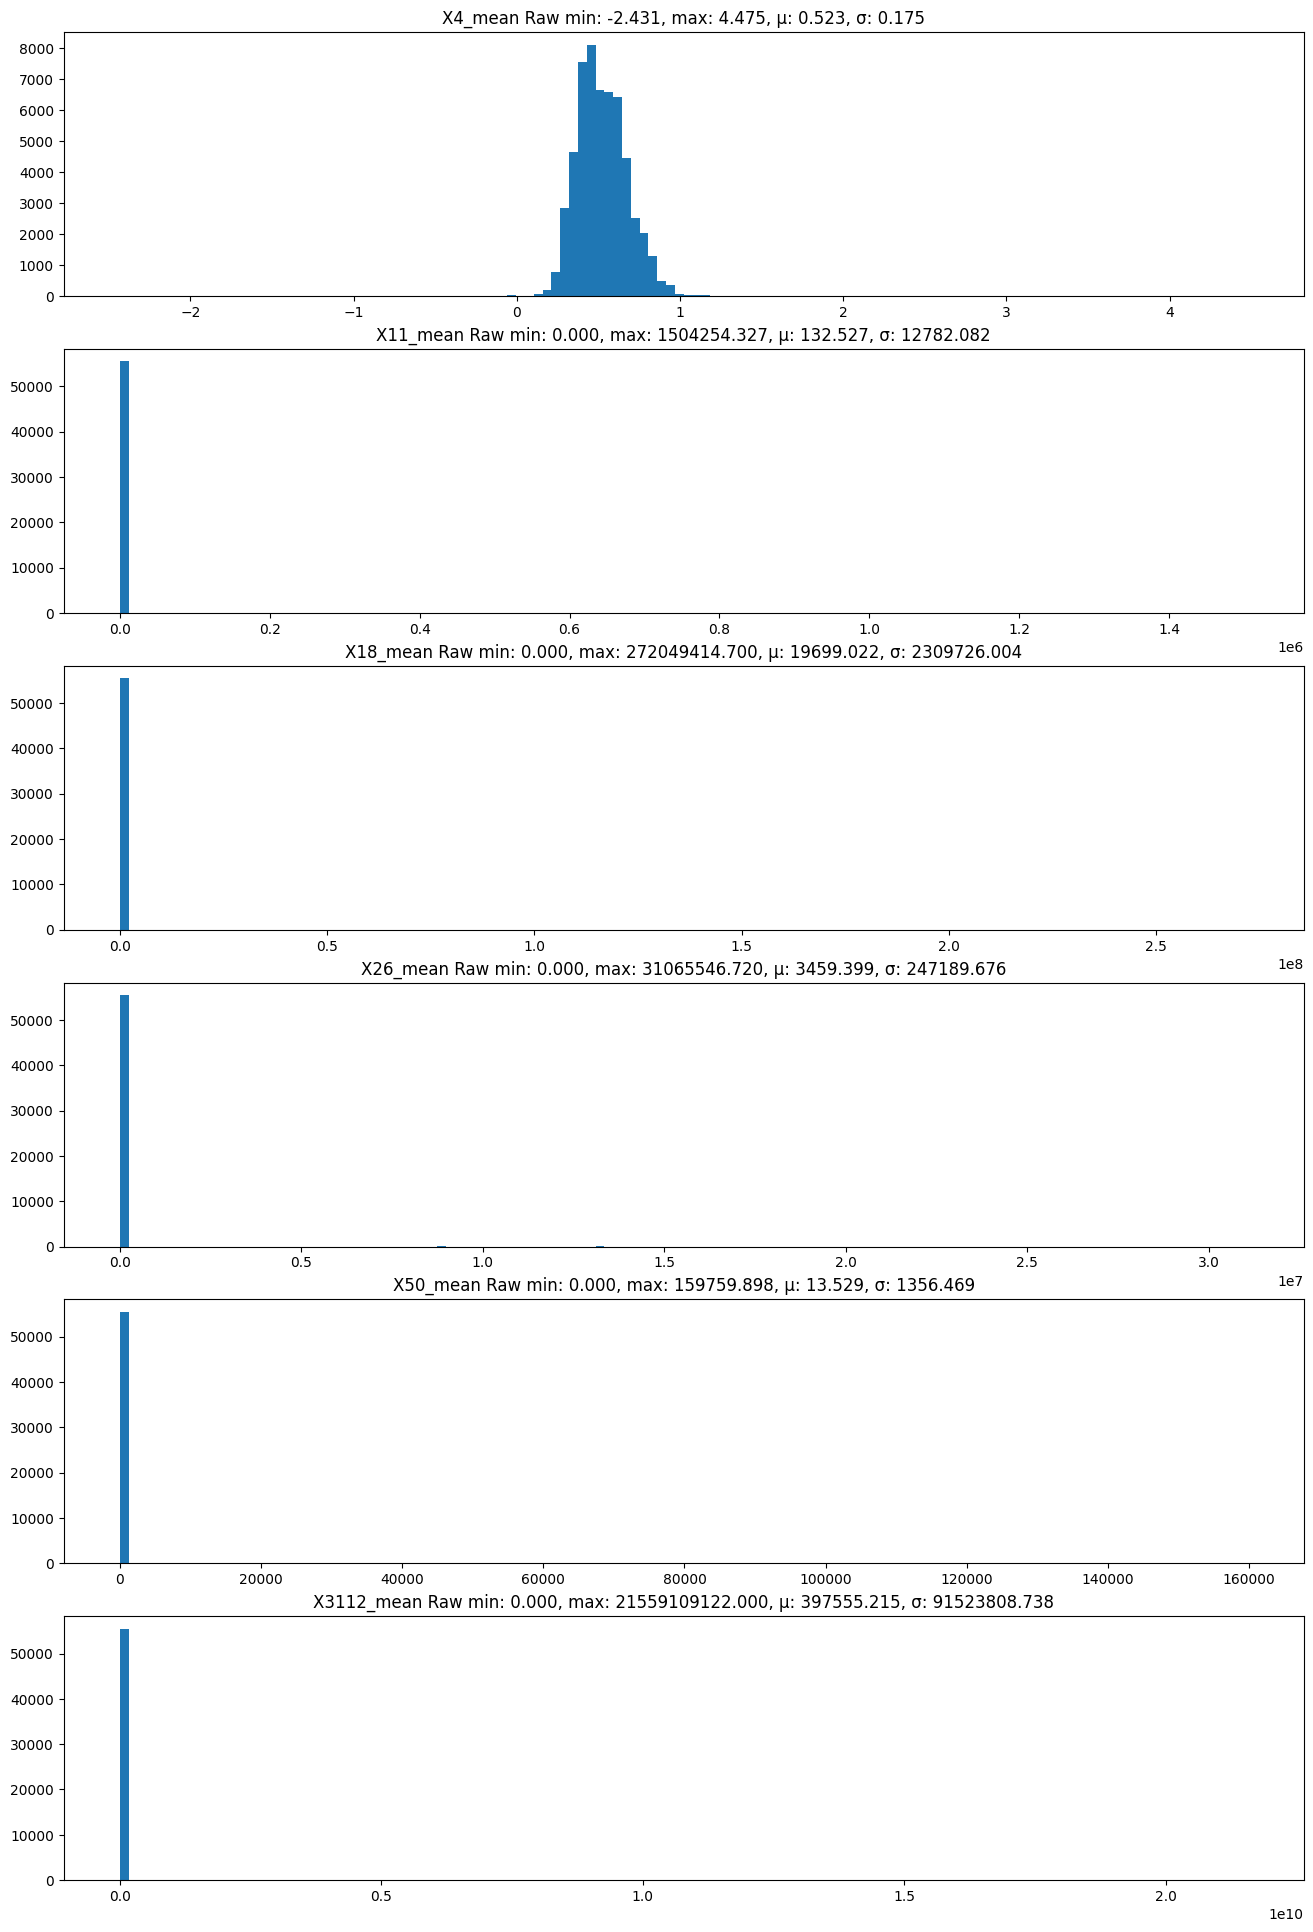

In [ ]:
obs_fig, obs_axes = plt.subplots(len(target_cols),1,figsize=(16,4*len(target_cols)))
obs_vals = train_df[target_cols].values

for ax, obs_label, obs_v in zip(obs_axes, target_cols, obs_vals.T):
  ax.hist(obs_v, bins=128)
  ax.set_title(f'{obs_label} Raw min: {obs_v.min():.3f}, max: {obs_v.max():.3f}, µ: {obs_v.mean():.3f}, σ: {obs_v.std():.3f}', size=12)

plt.show()

We can notice that besides X4_mean, the other values are too large, which means some sort of log normalization should be done later on.

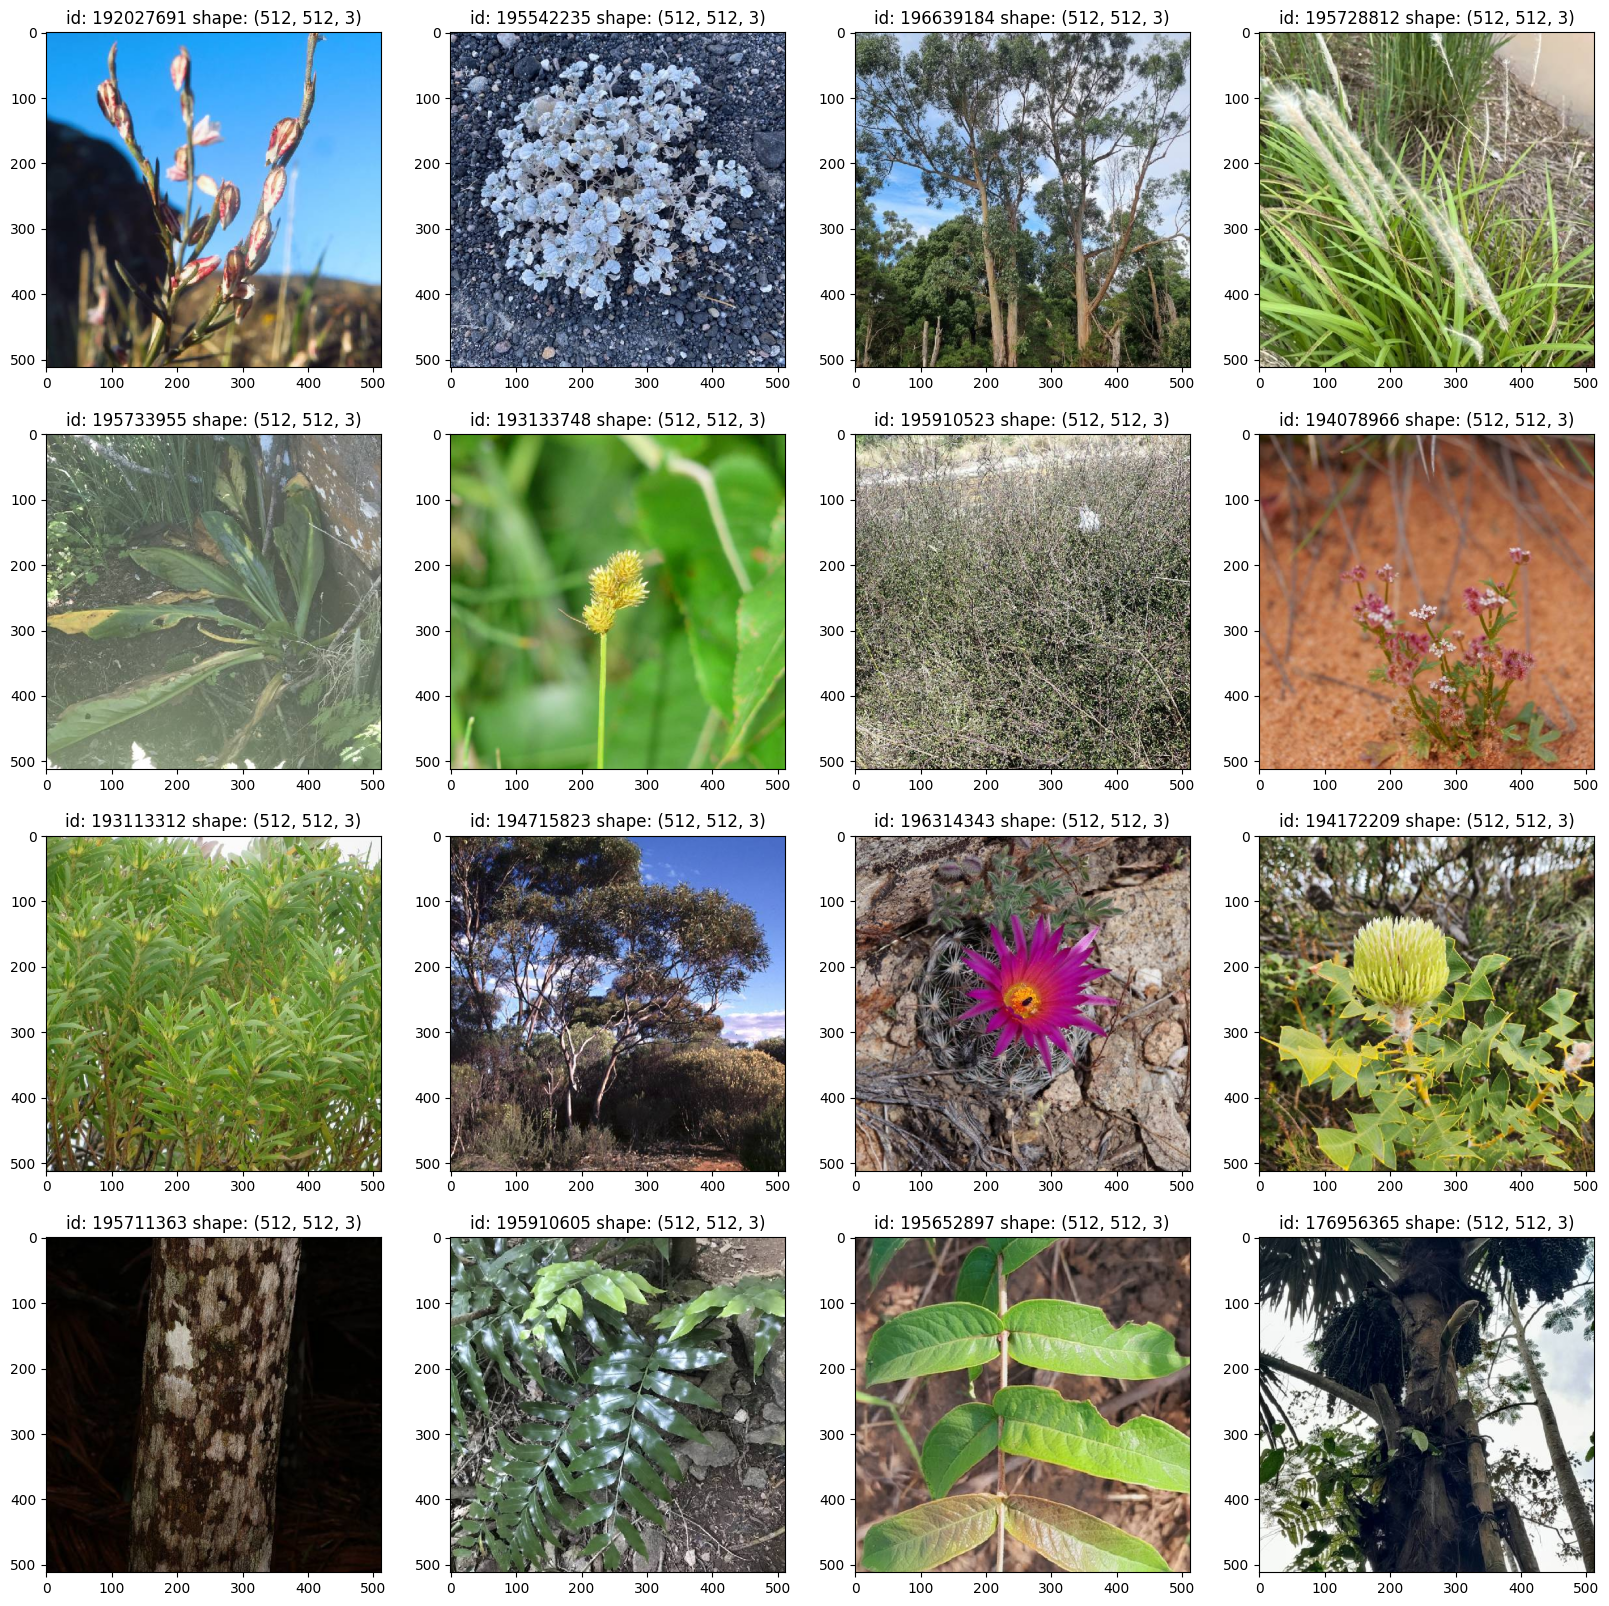

In [ ]:
example_fig, example_axes = plt.subplots(4,4,figsize=(20,20))
for r in range(4):
  for c in range(4):
    example_img = imageio.imread(train_df['image'][5*r+c])
    example_axes[r,c].imshow(example_img)
    example_axes[r,c].set_title(f"id: {train_df['id'][5*r+c]} shape: {example_img.shape}")

We can notice that certain traits cannot be articulated only by vision.<br>
For example, X50 seems to depend on nitrogen content over the leaf. Since nitrogen is clearly colorless, we need to use the other values provided in train.csv to make a better estimate.<br> Nevertheless, we try using the images only first as a baseline effort.

# Step 3: Training a simple CNN network (ResNet50)

To understand the performance, we trained a normal CNN network. This serves as a baseline to see how much prediction power the images on their own have.

In [ ]:
# Write a dataloader

class DatasetPlants(Dataset):
    def __init__(self, X_jpeg_bytes, y, transforms=None):
        self.X_jpeg_bytes = X_jpeg_bytes
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return len(self.X_jpeg_bytes)

    def __getitem__(self, index):
        X_sample = self.transforms(
            image=imageio.imread(self.X_jpeg_bytes[index]),
        )['image']
        y_sample = self.y[index]

        return X_sample, y_sample

In [ ]:
train_set_df, validation_set_df = train_test_split(train_df, test_size=0.1)

In [ ]:
# Prepare output labels

scaler = StandardScaler()

y_train = np.zeros_like(train_set_df[np.array(target_cols)], dtype=np.float32)
y_validation = np.zeros_like(validation_set_df[np.array(target_cols)], dtype=np.float32)
for target_idx, target in enumerate(target_cols):
    v1 = train_set_df[target].values
    v2 = validation_set_df[target].values
    if target != 'X4_mean':
        # Scale to log10 as noted before
        v1 = np.log10(v1)
        v2 = np.log10(v2)
    y_train[:,target_idx] = v1
    y_validation[:,target_idx] = v2

# Apply Scaler
y_train = scaler.fit_transform(y_train)
y_validation = scaler.fit_transform(y_validation)

In [ ]:
# Normalize

transform_pipe = A.Compose([
    # Resize image to 224 x 224
    A.Resize(
        224,
        224,
        always_apply = True,
    ),
    A.ToFloat(),

    # Normalize the mean and standard dev
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=1
    ),

    # Converts images to tensors
    ToTensorV2(),
])

In [ ]:
# Train
train_dataset = DatasetPlants(
    train_set_df['image'].values,
    y_train,
    transform_pipe
)

train_dataloader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
    )

# Validation
validation_dataset = DatasetPlants(
    validation_set_df['image'].values,
    y_validation,
    transform_pipe
)

validation_dataloader = DataLoader(
        validation_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
)

# Test
test_dataset = DatasetPlants(
    test_df['image'].values,
    test_df['id'].values,
    transform_pipe
)

In [ ]:
class ModelBase(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
                'resnet50.a1_in1k',
                pretrained=True,
                num_classes=6,
            )

    def forward(self, inputs):
        return self.backbone(inputs)

In [ ]:
# R2 loss w/ scaling
def r2_loss(y_pred, y_true, y_mean, eps):
    ss_res = torch.sum((y_true - y_pred)**2, dim=0)
    ss_total = torch.sum((y_true - y_mean)**2, dim=0)
    ss_total = torch.maximum(ss_total, eps)
    r2 = torch.mean(ss_res / ss_total)
    return r2

In [ ]:
model_base = ModelBase()
optimizer_base = torch.optim.AdamW(
    params=model_base.parameters(),
    lr=3e-4,
    weight_decay=0.01,
)
loss_fn_base = r2_loss

In [ ]:
def print_time(start, end):
    total_time = end - start
    print(f"Time taken: {total_time:.3f} seconds")
    return total_time

In [ ]:
# Our training function

def train_model(dataloaders, y_labels, model, device, epochs, optimizer, loss_fn, print_at):
  losses = {"train": [], "validation": []}
  start_time = timer()
  model = model.to(device)
  y_train_mean = torch.tensor(y_labels["train"]).mean(dim=0).to(device)
  y_validation_mean = torch.tensor(y_labels["validation"]).mean(dim=0).to(device)
  eps = torch.tensor([1e-6]).to(device)
  for i in range(epochs):
    use_mean = None
    for phase in ["train", "validation"]:
      epoch_err_total = 0.0
      count = 0
      if phase == "train":
        model.train()
        use_mean = y_train_mean
      else:
        model.eval()
        use_mean = y_validation_mean

      for j, (X, labels) in enumerate(dataloaders[phase]):
        X = X.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == "train"):
          y = model(X)

          loss = loss_fn(y, labels, use_mean, eps)

          epoch_err_total += loss.sum()
          count += loss.numel()
          if phase == "train":
            loss.backward()
            optimizer.step()

          if (j % print_at) == (print_at-1) and phase == "train":
            print(f"epoch: {i+1}, step: {j+1} = loss: {epoch_err_total/count}")

      # Print epoch stats
      print(f"epoch: {i+1} = {phase} loss: {epoch_err_total/count}")
      losses[phase].append(epoch_err_total/count)
  end_time = timer()
  print_time(start_time, end_time)
  return losses

In [ ]:
losses = train_model({"train": train_dataloader, "validation": validation_dataloader}, {"train": y_train, "validation": y_validation}, model_base, device, 10, optimizer_base, loss_fn_base, 50)

epoch: 1, step: 50 = loss: 0.9715389609336853
epoch: 1, step: 100 = loss: 0.9361171722412109
epoch: 1, step: 150 = loss: 0.9052735567092896
epoch: 1, step: 200 = loss: 0.8891160488128662
epoch: 1, step: 250 = loss: 0.8759942650794983
epoch: 1, step: 300 = loss: 0.866523265838623
epoch: 1, step: 350 = loss: 0.8598939776420593
epoch: 1, step: 400 = loss: 0.8501603603363037
epoch: 1, step: 450 = loss: 0.8426316380500793
epoch: 1, step: 500 = loss: 0.8364694118499756
epoch: 1, step: 550 = loss: 0.8316590785980225
epoch: 1, step: 600 = loss: 0.827424943447113
epoch: 1, step: 650 = loss: 0.8229137063026428
epoch: 1, step: 700 = loss: 0.8196348547935486
epoch: 1, step: 750 = loss: 0.8173728585243225
epoch: 1, step: 800 = loss: 0.8142855167388916
epoch: 1, step: 850 = loss: 0.8114761710166931
epoch: 1, step: 900 = loss: 0.8107489943504333
epoch: 1, step: 950 = loss: 0.8095598816871643
epoch: 1, step: 1000 = loss: 0.8072295784950256
epoch: 1, step: 1050 = loss: 0.8051409125328064
epoch: 1, step

In [ ]:
losses_cpu = {}

for a in losses:
  losses_cpu[a] = []
  for b in losses[a]:
    losses_cpu[a].append(b.detach().cpu().item())

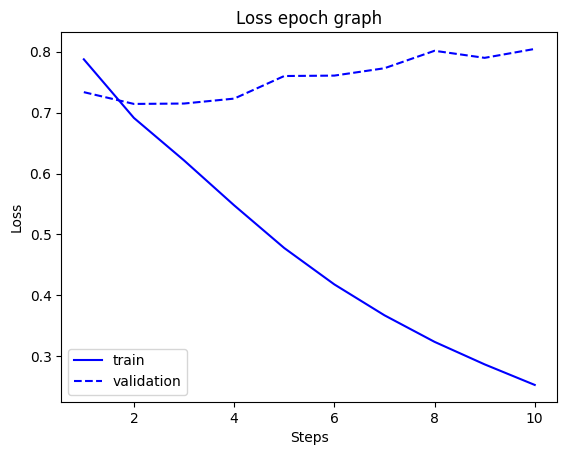

In [ ]:
plt.plot(range(1, len(losses_cpu["train"])+1), losses_cpu["train"], label='train', color='b')
plt.plot(range(1, len(losses_cpu["validation"])+1), losses_cpu["validation"], label='validation', color='b', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss epoch graph')
plt.legend()

In [ ]:
import pickle

# Save model & data
torch.save(model_base, 'model_base.pth')
with open('model_base_losses.pickle', 'wb') as handle:
    pickle.dump(losses_cpu, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Our test function -- To get results, we have to submit to kaggle since they have not provided test values

def test_model(test_dataset, model, device, scaler, target_cols):
  submission = []

  # Important to put model into test mode -- since layers like dropout etc differs between training and testing
  model.eval()
  for X_sample_test, test_id in tqdm(test_dataset):
    with torch.no_grad():
      y_pred = model(X_sample_test.unsqueeze(0).to(device)).detach().cpu().numpy()
      # Reverse Scaling
      y_pred = scaler.inverse_transform(y_pred).squeeze()

      row = {'id': test_id }
      for k, v in zip(target_cols, y_pred):
        # Remove "_mean" part of target column
        if k != 'X4_mean':
            row[k.replace('_mean', '')] = 10 ** v
        else:
            row[k.replace('_mean', '')] = v

      submission.append(row)
  return submission

In [ ]:
submission_arr = test_model(test_dataset, model_base, device, scaler, target_cols)

  0%|          | 0/13873 [00:00<?, ?it/s]

In [ ]:
submission_df = pd.DataFrame(submission_arr)

display(submission_df.head())

submission_df.to_csv('submission.csv', index=False)

id        X4        X11        X18        X26       X50        X3112
0  195066138  0.498196  19.389433   0.682948   0.835189  1.020874  1108.523055
1  195524180  0.418621   5.554619  46.414113  11.086962  2.024307    40.632316
2  172220512  0.441228  17.755851   4.405529  21.845562  1.334040  4786.863994
3  195824490  0.530062  14.203710   1.002578   3.365634  1.594976  1305.790712
4  191793047  0.553918  14.216110   1.202950   3.684138  1.350484   770.457261

The results from this kaggle submission comes out to be:
![sub1](https://i.ibb.co/RN3mJ8P/res1.png)
We notice that the results is poor (hinted from the overfitting in the epoch loss graph). This can be attributed to many factors including using only 10 epochs to not using any other special techniques.<br>
The next section tries to use more techniques which may be helpful in improving the score.

# Step 4: Training a more elevated CNN (ResNet50)
In this step, we try to improve the performance by applying (more) data augmentation and a learning rate scheduler.<br>
In the previous section, we did utilize regularization since ResNet50 contains droupout layers. We also used a pretrained ResNet50 model from Hugging Face.

In [ ]:
# Augmentation

updated_transform_pipe = A.Compose([
    # Randomly flip images
    A.HorizontalFlip(p=0.5),
    # Also crop images and then resize images to 224 x 224
    A.RandomSizedCrop(
      [384, 512],
      224, 224, w2h_ratio=1.0, p=1.0
    ),
    # Also randomly adjust brightness
    A.RandomBrightnessContrast(brightness_limit=0.10, contrast_limit=0.10, p=0.50),
    # Also randomly change the compression
    A.ImageCompression(quality_lower=75, quality_upper=100, p=0.5),
    A.ToFloat(),

    # Normalize the mean and standard dev
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=1
    ),

    # Converts images to tensors
    ToTensorV2(),
])

test_transformation_pipe = A.Compose([
    # Resize image to 224 x 224
    A.Resize(
        224,
        224,
        always_apply = True,
    ),
    A.ToFloat(),

    # Normalize the mean and standard dev
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=1
    ),

    # Converts images to tensors
    ToTensorV2(),
])

In [ ]:
# Setup a learning scheduler

def make_scheduler(optimizer):
  return torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=3e-4,
        total_steps=len(y_validation) // 32 * 10 + len(y_train) // 32 * 10 + 2,
        pct_start=0.10,
        anneal_strategy='cos',
        div_factor=1e3,
        final_div_factor=1e4,
    )

In [ ]:
model_elevated = ModelBase()
optimizer_elevated = torch.optim.AdamW(
    params=model_elevated.parameters(),
    lr=3e-4,
    weight_decay=0.01,
)
loss_fn_elevated = r2_loss
scheduler_elevated = make_scheduler(optimizer_elevated)

In [ ]:
# Train
train_dataset = DatasetPlants(
    train_set_df['image'].values,
    y_train,
    updated_transform_pipe
)

train_dataloader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
    )

# Validation
validation_dataset = DatasetPlants(
    validation_set_df['image'].values,
    y_validation,
    updated_transform_pipe
)

validation_dataloader = DataLoader(
        validation_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
)

# Test
test_dataset = DatasetPlants(
    test_df['image'].values,
    test_df['id'].values,
    test_transformation_pipe
)

In [ ]:
# Our training function V2

def train_modelV2(dataloaders, y_labels, model, device, epochs, optimizer, loss_fn, scheduler, print_at):
  losses = {"train": [], "validation": []}
  start_time = timer()
  model = model.to(device)
  y_train_mean = torch.tensor(y_labels["train"]).mean(dim=0).to(device)
  y_validation_mean = torch.tensor(y_labels["validation"]).mean(dim=0).to(device)
  eps = torch.tensor([1e-6]).to(device)
  for i in range(epochs):
    use_mean = None
    for phase in ["train", "validation"]:
      epoch_err_total = 0.0
      count = 0
      if phase == "train":
        model.train()
        use_mean = y_train_mean
      else:
        model.eval()
        use_mean = y_validation_mean

      for j, (X, labels) in enumerate(dataloaders[phase]):
        X = X.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == "train"):
          y = model(X)

          loss = loss_fn(y, labels, use_mean, eps)

          epoch_err_total += loss.sum()
          count += loss.numel()
          if phase == "train":
            loss.backward()
            optimizer.step()

          scheduler.step()
          if (j % print_at) == (print_at-1) and phase == "train":
            print(f"epoch: {i+1}, step: {j+1} = loss: {epoch_err_total/count}")

      # Print epoch stats
      print(f"epoch: {i+1} = {phase} loss: {epoch_err_total/count}")
      losses[phase].append(epoch_err_total/count)
  end_time = timer()
  print_time(start_time, end_time)
  return losses

In [ ]:
losses2 = train_modelV2({"train": train_dataloader, "validation": validation_dataloader}, {"train": y_train, "validation": y_validation}, model_elevated, device, 10, optimizer_elevated, loss_fn_elevated, scheduler_elevated, 50)

epoch: 1, step: 50 = loss: 1.0088399648666382
epoch: 1, step: 100 = loss: 1.0119194984436035
epoch: 1, step: 150 = loss: 1.0117840766906738
epoch: 1, step: 200 = loss: 1.0102077722549438
epoch: 1, step: 250 = loss: 1.0089436769485474
epoch: 1, step: 300 = loss: 1.0070884227752686
epoch: 1, step: 350 = loss: 1.0052118301391602
epoch: 1, step: 400 = loss: 1.0024757385253906
epoch: 1, step: 450 = loss: 0.9996928572654724
epoch: 1, step: 500 = loss: 0.9960867166519165
epoch: 1, step: 550 = loss: 0.9922661781311035
epoch: 1, step: 600 = loss: 0.9873633980751038
epoch: 1, step: 650 = loss: 0.981791079044342
epoch: 1, step: 700 = loss: 0.975249707698822
epoch: 1, step: 750 = loss: 0.9673225283622742
epoch: 1, step: 800 = loss: 0.9604098200798035
epoch: 1, step: 850 = loss: 0.9529838562011719
epoch: 1, step: 900 = loss: 0.9450417757034302
epoch: 1, step: 950 = loss: 0.9377288222312927
epoch: 1, step: 1000 = loss: 0.9313236474990845
epoch: 1, step: 1050 = loss: 0.9253290891647339
epoch: 1, step

In [ ]:
losses2_cpu = {}

for a in losses2:
  losses2_cpu[a] = []
  for b in losses2[a]:
    losses2_cpu[a].append(b.detach().cpu().item())

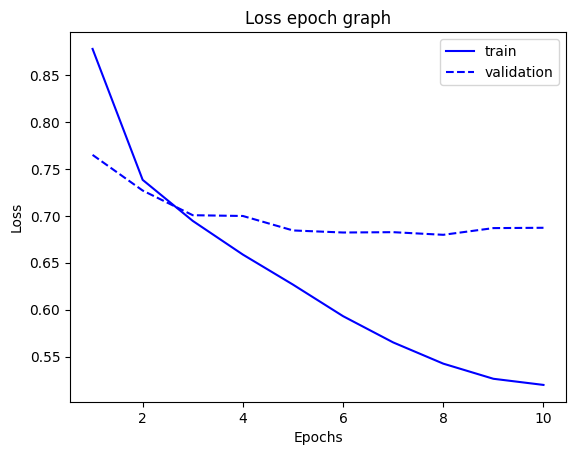

In [ ]:
plt.plot(range(1, len(losses2_cpu["train"])+1), losses2_cpu["train"], label='train', color='b')
plt.plot(range(1, len(losses2_cpu["validation"])+1), losses2_cpu["validation"], label='validation', color='b', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss epoch graph')
plt.legend()

In [ ]:
import pickle

# Save model & data
torch.save(model_elevated, 'model_elevated.pth')
with open('model_elevated_losses.pickle', 'wb') as handle:
    pickle.dump(losses2_cpu, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Our test function -- To get results, we have to submit to kaggle since they have not provided test values

def test_model(test_dataset, model, device, scaler, target_cols):
  submission = []

  # Important to put model into test mode -- since layers like dropout etc differs between training and testing
  model.eval()
  for X_sample_test, test_id in tqdm(test_dataset):
    with torch.no_grad():
      y_pred = model(X_sample_test.unsqueeze(0).to(device)).detach().cpu().numpy()
      # Reverse Scaling
      y_pred = scaler.inverse_transform(y_pred).squeeze()

      row = {'id': test_id }
      for k, v in zip(target_cols, y_pred):
        # Remove "_mean" part of target column
        if k != 'X4_mean':
            row[k.replace('_mean', '')] = 10 ** v
        else:
            row[k.replace('_mean', '')] = v

      submission.append(row)
  return submission

In [ ]:
submission_arr = test_model(test_dataset, model_elevated, device, scaler, target_cols)

  0%|          | 0/13873 [00:00<?, ?it/s]

In [ ]:
submission_df = pd.DataFrame(submission_arr)

display(submission_df.head())

submission_df.to_csv('submission.csv', index=False)

id        X4        X11        X18       X26       X50        X3112
0  195066138  0.436038  20.308306   0.493088  0.907154  1.049940   947.497335
1  195524180  0.501809   8.546140  11.136314  9.465574  1.808764   100.201073
2  172220512  0.538807  18.676938   3.265962  7.339517  1.147778  3091.389941
3  195824490  0.542459  13.060983   0.637903  2.622285  1.801232   441.716142
4  191793047  0.405599  22.695001   0.333375  0.918184  1.103168  1073.851795

The results from this kaggle submission comes out to be:
![sub1](https://i.ibb.co/1JLKS77/res2.png)
The result is significantly better than the previous model, however it is still poor. We can notice that increasing the epochs might not do much, since the validation score stalls out after a while.<br>
Finding out different augmentation techniques or parameters can improve it, but the true essence is that we need to utilize additional information provided or use a different model other than the ResNet50.<br>
The next section tries to combine different models in hopes to improve the accuracy.

# Step 5: Ensemble models
Notice that the train.csv file provides more details other than the labels for the images. We explained before that certain traits like nitrogen levels are difficult to observe with visual ques only.<br>
So, we can train seperate models which can give suggestive features in order to make the prediction more accurate.<br>
Three prominent models can established:
*   Vision model
*   Temperature model
*   Soil model

The vision model tries to intercept the images (the last model we trained)<br>
The temperature model tries to use the WORLDCLIMATE data provided to make a prediction<br>
The Soil model tries to use the SOIL data provided to make a prediction<br>
Additionally, there are satalite information provided which we can try to use in conjuction with the Vision model.



In [ ]:
# Same dataloader from before

class DatasetPlants(Dataset):
    def __init__(self, X_df, y, transforms=None):
        self.X_jpeg_bytes = X_df['image'].values
        self.numeric = torch.tensor(X_df[[col for col in X_df.columns if 'MODIS' in col or 'VOD' in col]].values)
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return len(self.X_jpeg_bytes)

    def __getitem__(self, index):
        X_sample = self.transforms(
            image=imageio.imread(self.X_jpeg_bytes[index]),
        )['image']
        y_sample = self.y[index]

        return X_sample, self.numeric[index], y_sample

In [ ]:
train_set_df, validation_set_df = train_test_split(train_df, test_size=0.1)

In [ ]:
# Prepare output labels

scaler = StandardScaler()

y_train = np.zeros_like(train_set_df[np.array(target_cols)], dtype=np.float32)
y_validation = np.zeros_like(validation_set_df[np.array(target_cols)], dtype=np.float32)
for target_idx, target in enumerate(target_cols):
    v1 = train_set_df[target].values
    v2 = validation_set_df[target].values
    if target != 'X4_mean':
        # Scale to log10 as noted before
        v1 = np.log10(v1)
        v2 = np.log10(v2)
    y_train[:,target_idx] = v1
    y_validation[:,target_idx] = v2

# Apply Scaler
y_train = scaler.fit_transform(y_train)
y_validation = scaler.fit_transform(y_validation)

In [ ]:
# Augmentation

transform_pipe = A.Compose([
    # Randomly flip images
    A.HorizontalFlip(p=0.5),
    # Also crop images and then resize images to 224 x 224
    A.RandomSizedCrop(
      [384, 512],
      224, 224, w2h_ratio=1.0, p=1.0
    ),
    # Also randomly adjust brightness
    A.RandomBrightnessContrast(brightness_limit=0.10, contrast_limit=0.10, p=0.50),
    # Also randomly change the compression
    A.ImageCompression(quality_lower=75, quality_upper=100, p=0.5),
    A.ToFloat(),

    # Normalize the mean and standard dev
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=1
    ),

    # Converts images to tensors
    ToTensorV2(),
])

test_transformation_pipe = A.Compose([
    # Resize image to 224 x 224
    A.Resize(
        224,
        224,
        always_apply = True,
    ),
    A.ToFloat(),

    # Normalize the mean and standard dev
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=1
    ),

    # Converts images to tensors
    ToTensorV2(),
])

In [ ]:
# Train
train_dataset = DatasetPlants(
    train_set_df,
    y_train,
    transform_pipe
)

train_dataloader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
    )

# Validation
validation_dataset = DatasetPlants(
    validation_set_df,
    y_validation,
    transform_pipe
)

validation_dataloader = DataLoader(
        validation_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
)

# Test
test_dataset = DatasetPlants(
    test_df,
    test_df['id'].values,
    test_transformation_pipe
)

In [ ]:
class ModelVision(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
                'resnet50.a1_in1k',
                pretrained=True,
                num_classes=25,
            )
        self.mlp = nn.Sequential(OrderedDict([
            ('dense1', nn.Linear(121, 100)),
            ('a1', nn.ReLU()),
            ('dense2', nn.Linear(100, 50)),
            ('a2', nn.ReLU()),
            ('dense3', nn.Linear(50,20)),
            ('a3', nn.ReLU()),
            ('dense4', nn.Linear(20, 10)),
            ('a4', nn.ReLU()),
            ('output', nn.Linear(10, 6)),
        ]))

    def forward(self, inputs_img, inputs_numeric):
      cnn_out = self.backbone(inputs_img)
      merged = torch.cat((cnn_out, inputs_numeric.float()),1)
      return self.mlp(merged)

In [ ]:
# R2 loss w/ scaling
def r2_loss(y_pred, y_true, y_mean, eps):
    ss_res = torch.sum((y_true - y_pred)**2, dim=0)
    ss_total = torch.sum((y_true - y_mean)**2, dim=0)
    ss_total = torch.maximum(ss_total, eps)
    r2 = torch.mean(ss_res / ss_total)
    return r2

In [ ]:
# Setup a learning scheduler

def make_scheduler(optimizer):
  return torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=3e-4,
        total_steps=len(y_validation) // 32 * 10 + len(y_train) // 32 * 10 + 2,
        pct_start=0.10,
        anneal_strategy='cos',
        div_factor=1e3,
        final_div_factor=1e4,
    )

In [ ]:
model_vision = ModelVision()
optimizer_vision = torch.optim.AdamW(
    params=model_vision.parameters(),
    lr=3e-4,
    weight_decay=0.01,
)
loss_fn_vision = r2_loss
scheduler_vision = make_scheduler(optimizer_vision)

In [ ]:
def print_time(start, end):
    total_time = end - start
    print(f"Time taken: {total_time:.3f} seconds")
    return total_time

In [ ]:
# Our vision train

def train_vision(dataloaders, y_labels, model, device, epochs, optimizer, loss_fn, scheduler, print_at):
  losses = {"train": [], "validation": []}
  start_time = timer()
  model = model.to(device)
  y_train_mean = torch.tensor(y_labels["train"]).mean(dim=0).to(device)
  y_validation_mean = torch.tensor(y_labels["validation"]).mean(dim=0).to(device)
  eps = torch.tensor([1e-6]).to(device)
  for i in range(epochs):
    use_mean = None
    for phase in ["train", "validation"]:
      epoch_err_total = 0.0
      count = 0
      if phase == "train":
        model.train()
        use_mean = y_train_mean
      else:
        model.eval()
        use_mean = y_validation_mean

      for j, (X_img, X_numeric, labels) in enumerate(dataloaders[phase]):
        X_img = X_img.to(device)
        X_numeric = X_numeric.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == "train"):
          y = model(X_img, X_numeric)

          loss = loss_fn(y, labels, use_mean, eps)

          epoch_err_total += loss.sum()
          count += loss.numel()
          if phase == "train":
            loss.backward()
            optimizer.step()

          scheduler.step()
          if (j % print_at) == (print_at-1) and phase == "train":
            print(f"epoch: {i+1}, step: {j+1} = loss: {epoch_err_total/count}")

      # Print epoch stats
      print(f"epoch: {i+1} = {phase} loss: {epoch_err_total/count}")
      losses[phase].append(epoch_err_total/count)
  end_time = timer()
  print_time(start_time, end_time)
  return losses

In [ ]:
losses3 = train_vision({"train": train_dataloader, "validation": validation_dataloader}, {"train": y_train, "validation": y_validation}, model_vision, device, 10, optimizer_vision, loss_fn_vision, scheduler_vision, 50)

epoch: 1, step: 50 = loss: 422.0657958984375
epoch: 1, step: 100 = loss: 421.4612731933594
epoch: 1, step: 150 = loss: 402.29656982421875
epoch: 1, step: 200 = loss: 368.7879638671875
epoch: 1, step: 250 = loss: 326.1386413574219
epoch: 1, step: 300 = loss: 283.078125
epoch: 1, step: 350 = loss: 246.6015625
epoch: 1, step: 400 = loss: 217.83572387695312
epoch: 1, step: 450 = loss: 194.9107208251953
epoch: 1, step: 500 = loss: 176.2425079345703
epoch: 1, step: 550 = loss: 160.8594970703125
epoch: 1, step: 600 = loss: 147.869873046875
epoch: 1, step: 650 = loss: 136.75576782226562
epoch: 1, step: 700 = loss: 127.20394897460938
epoch: 1, step: 750 = loss: 118.87737274169922
epoch: 1, step: 800 = loss: 111.57632446289062
epoch: 1, step: 850 = loss: 105.11434173583984
epoch: 1, step: 900 = loss: 99.36143493652344
epoch: 1, step: 950 = loss: 94.21269226074219
epoch: 1, step: 1000 = loss: 89.56893157958984
epoch: 1, step: 1050 = loss: 85.36592864990234
epoch: 1, step: 1100 = loss: 81.54163360

In [ ]:
losses3_cpu = {}

for a in losses3:
  losses3_cpu[a] = []
  for b in losses3[a]:
    losses3_cpu[a].append(b.detach().cpu().item())

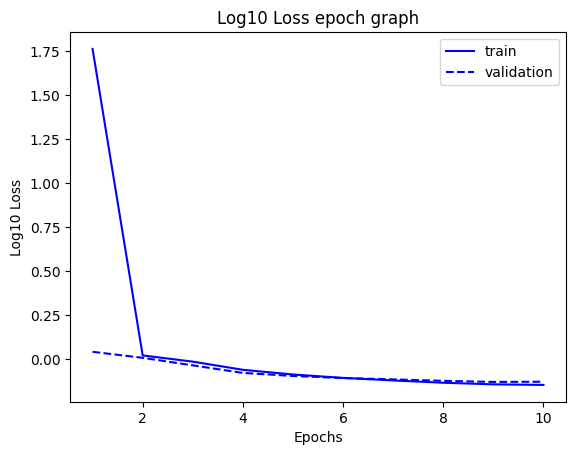

In [ ]:
plt.plot(range(1, len(losses3_cpu["train"])+1), np.log10(losses3_cpu["train"]), label='train', color='b')
plt.plot(range(1, len(losses3_cpu["validation"])+1), np.log10(losses3_cpu["validation"]), label='validation', color='b', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Log10 Loss')
plt.title('Log10 Loss epoch graph')
plt.legend()

In [ ]:
import pickle

# Save model & data
torch.save(model_vision, 'model_vision.pth')
with open('model_vision_losses.pickle', 'wb') as handle:
    pickle.dump(losses3_cpu, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Our test function -- To get results, we have to submit to kaggle since they have not provided test values

def test_model(test_dataset, model, device, scaler, target_cols):
  submission = []

  # Important to put model into test mode -- since layers like dropout etc differs between training and testing
  model.eval()
  for X_sample_test, X_input_numeric, test_id in tqdm(test_dataset):
    with torch.no_grad():
      y_pred = model(X_sample_test.unsqueeze(0).to(device), X_input_numeric.unsqueeze(0).to(device)).detach().cpu().numpy()
      # Reverse Scaling
      y_pred = scaler.inverse_transform(y_pred).squeeze()

      row = {'id': test_id }
      for k, v in zip(target_cols, y_pred):
        # Remove "_mean" part of target column
        if k != 'X4_mean':
            row[k.replace('_mean', '')] = 10 ** v
        else:
            row[k.replace('_mean', '')] = v

      submission.append(row)
  return submission

In [ ]:
submission1_arr = test_model(test_dataset, model_vision, device, scaler, target_cols) # A seperate model submission if needed

  0%|          | 0/13873 [00:00<?, ?it/s]

In [ ]:
submission1_df = pd.DataFrame(submission1_arr)

display(submission1_df.head())

submission1_df.to_csv('submission1.csv', index=False)

id        X4        X11       X18        X26       X50        X3112
0  195066138  0.438909  22.225240  0.401556   0.800412  1.165052   724.452489
1  195524180  0.533840  16.987533  2.503901   7.411544  1.403358  2245.907122
2  172220512  0.591715  12.363149  4.749430  19.766284  1.666996  2343.175723
3  195824490  0.554844  10.639516  1.503349   5.590048  1.635374   548.206039
4  191793047  0.420040  17.941694  0.287347   0.553988  1.532744   268.556645

In [ ]:
class ModelWeather(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(OrderedDict([
            ('dense1', nn.Linear(6, 10)),
            ('a1', nn.ReLU()),
            ('dense2', nn.Linear(10, 25)),
            ('a2', nn.ReLU()),
            ('dense3', nn.Linear(25,50)),
            ('a3', nn.ReLU()),
            ('dense4', nn.Linear(50, 25)),
            ('a4', nn.ReLU()),
            ('dense5', nn.Linear(25, 10)),
            ('a5', nn.ReLU()),
            ('output', nn.Linear(10, 6)),
        ]))

    def forward(self, inputs):
      return self.mlp(inputs.float())

In [ ]:
class DatasetWeather:
    def __init__(self, X_df, y):
        self.weather = torch.tensor(X_df[[col for col in X_df.columns if 'WORLDCLIM' in col]].values)
        self.y = y

    def __len__(self):
        return len(self.weather)

    def __getitem__(self, index):
        y_sample = self.y[index]

        return self.weather[index], y_sample

In [ ]:
# Train
train_dataset = DatasetWeather(
    train_set_df,
    y_train,
)

train_dataloader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
    )

# Validation
validation_dataset = DatasetWeather(
    validation_set_df,
    y_validation,
)

validation_dataloader = DataLoader(
        validation_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
)

# Test
test_dataset = DatasetWeather(
    test_df,
    test_df['id'].values,
)

In [ ]:
model_weather = ModelWeather()
optimizer_weather = torch.optim.AdamW(
    params=model_weather.parameters(),
    lr=3e-4,
    weight_decay=0.01,
)
loss_fn_weather = r2_loss
scheduler_weather = make_scheduler(optimizer_weather)

In [ ]:
# Our train function

def train(dataloaders, y_labels, model, device, epochs, optimizer, loss_fn, scheduler, print_at):
  losses = {"train": [], "validation": []}
  start_time = timer()
  model = model.to(device)
  y_train_mean = torch.tensor(y_labels["train"]).mean(dim=0).to(device)
  y_validation_mean = torch.tensor(y_labels["validation"]).mean(dim=0).to(device)
  eps = torch.tensor([1e-6]).to(device)
  for i in range(epochs):
    use_mean = None
    for phase in ["train", "validation"]:
      epoch_err_total = 0.0
      count = 0
      if phase == "train":
        model.train()
        use_mean = y_train_mean
      else:
        model.eval()
        use_mean = y_validation_mean

      for j, (X, labels) in enumerate(dataloaders[phase]):
        X = X.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == "train"):
          y = model(X)

          loss = loss_fn(y, labels, use_mean, eps)

          epoch_err_total += loss.sum()
          count += loss.numel()
          if phase == "train":
            loss.backward()
            optimizer.step()

          scheduler.step()
          if (j % print_at) == (print_at-1) and phase == "train":
            print(f"epoch: {i+1}, step: {j+1} = loss: {epoch_err_total/count}")

      # Print epoch stats
      print(f"epoch: {i+1} = {phase} loss: {epoch_err_total/count}")
      losses[phase].append(epoch_err_total/count)
  end_time = timer()
  print_time(start_time, end_time)
  return losses

In [ ]:
loss4 = train({"train": train_dataloader, "validation": validation_dataloader}, {"train": y_train, "validation": y_validation}, model_weather, device, 10, optimizer_weather, loss_fn_weather, scheduler_weather, 50)

epoch: 1, step: 50 = loss: 5.036298751831055
epoch: 1, step: 100 = loss: 5.2062668800354
epoch: 1, step: 150 = loss: 5.136930465698242
epoch: 1, step: 200 = loss: 4.969393730163574
epoch: 1, step: 250 = loss: 4.773308277130127
epoch: 1, step: 300 = loss: 4.499120235443115
epoch: 1, step: 350 = loss: 4.210110664367676
epoch: 1, step: 400 = loss: 3.9184629917144775
epoch: 1, step: 450 = loss: 3.6417133808135986
epoch: 1, step: 500 = loss: 3.3963255882263184
epoch: 1, step: 550 = loss: 3.1861629486083984
epoch: 1, step: 600 = loss: 3.008612632751465
epoch: 1, step: 650 = loss: 2.856316089630127
epoch: 1, step: 700 = loss: 2.7250940799713135
epoch: 1, step: 750 = loss: 2.61202073097229
epoch: 1, step: 800 = loss: 2.511789560317993
epoch: 1, step: 850 = loss: 2.4234704971313477
epoch: 1, step: 900 = loss: 2.3454649448394775
epoch: 1, step: 950 = loss: 2.2748303413391113
epoch: 1, step: 1000 = loss: 2.211336612701416
epoch: 1, step: 1050 = loss: 2.1533701419830322
epoch: 1, step: 1100 = loss

In [ ]:
losses4_cpu = {}

for a in loss4:
  losses4_cpu[a] = []
  for b in loss4[a]:
    losses4_cpu[a].append(b.detach().cpu().item())

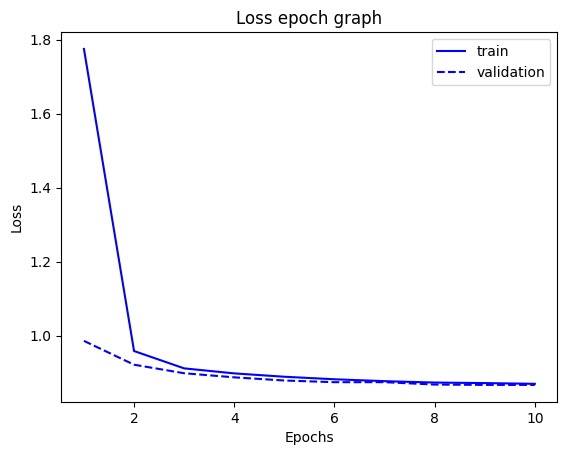

In [ ]:
plt.plot(range(1, len(losses4_cpu["train"])+1), losses4_cpu["train"], label='train', color='b')
plt.plot(range(1, len(losses4_cpu["validation"])+1), losses4_cpu["validation"], label='validation', color='b', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss epoch graph')
plt.legend()

In [ ]:
import pickle

# Save model & data
torch.save(model_weather, 'model_weather.pth')
with open('model_weather_losses.pickle', 'wb') as handle:
    pickle.dump(losses4_cpu, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Our test function -- To get results, we have to submit to kaggle since they have not provided test values

def test(test_dataset, model, device, scaler, target_cols):
  submission = []

  # Important to put model into test mode -- since layers like dropout etc differs between training and testing
  model.eval()
  for X_sample_test, test_id in tqdm(test_dataset):
    with torch.no_grad():
      y_pred = model(X_sample_test.unsqueeze(0).to(device)).detach().cpu().numpy()
      # Reverse Scaling
      y_pred = scaler.inverse_transform(y_pred).squeeze()

      row = {'id': test_id }
      for k, v in zip(target_cols, y_pred):
        # Remove "_mean" part of target column
        if k != 'X4_mean':
            row[k.replace('_mean', '')] = 10 ** v
        else:
            row[k.replace('_mean', '')] = v

      submission.append(row)
  return submission

In [ ]:
submission2_arr = test(test_dataset, model_weather, device, scaler, target_cols) # A seperate model submission if needed

  0%|          | 0/13873 [00:00<?, ?it/s]

In [ ]:
submission2_df = pd.DataFrame(submission2_arr)

display(submission2_df.head())

submission2_df.to_csv('submission2.csv', index=False)

id        X4        X11       X18        X26       X50        X3112
0  195066138  0.470096  17.771459  0.466755   1.114346  1.279234   576.062909
1  195524180  0.437519  20.747610  0.463229   0.943748  1.153782   720.936549
2  172220512  0.550193  15.367874  4.859630  16.825792  1.383365  3323.752050
3  195824490  0.539699  11.912619  0.848848   2.593673  1.687140   457.664783
4  191793047  0.453022  18.833791  0.326343   0.822781  1.212636   412.768175

In [ ]:
class ModelSoil(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(OrderedDict([
            ('dense1', nn.Linear(61, 75)),
            ('a1', nn.ReLU()),
            ('dense2', nn.Linear(75, 100)),
            ('a2', nn.ReLU()),
            ('dense3', nn.Linear(100,50)),
            ('a3', nn.ReLU()),
            ('dense4', nn.Linear(50, 25)),
            ('a4', nn.ReLU()),
            ('dense5', nn.Linear(25, 10)),
            ('a5', nn.ReLU()),
            ('output', nn.Linear(10, 6)),
        ]))

    def forward(self, inputs):
      return self.mlp(inputs.float())

In [ ]:
class DatasetSoil:
    def __init__(self, X_df, y):
        self.soil = torch.tensor(X_df[[col for col in X_df.columns if 'SOIL' in col]].values)
        self.y = y

    def __len__(self):
        return len(self.soil)

    def __getitem__(self, index):
        y_sample = self.y[index]

        return self.soil[index], y_sample

In [ ]:
# Train
train_dataset = DatasetSoil(
    train_set_df,
    y_train,
)

train_dataloader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
    )

# Validation
validation_dataset = DatasetSoil(
    validation_set_df,
    y_validation,
)

validation_dataloader = DataLoader(
        validation_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
)

# Test
test_dataset = DatasetSoil(
    test_df,
    test_df['id'].values,
)

In [ ]:
model_soil = ModelSoil()
optimizer_soil = torch.optim.AdamW(
    params=model_soil.parameters(),
    lr=3e-4,
    weight_decay=0.01,
)
loss_fn_soil = r2_loss
scheduler_soil = make_scheduler(optimizer_soil)

In [ ]:
losses5 = train({"train": train_dataloader, "validation": validation_dataloader}, {"train": y_train, "validation": y_validation}, model_soil, device, 10, optimizer_soil, loss_fn_soil, scheduler_soil, 50)

epoch: 1, step: 50 = loss: 2.166351318359375
epoch: 1, step: 100 = loss: 2.1840977668762207
epoch: 1, step: 150 = loss: 2.1096677780151367
epoch: 1, step: 200 = loss: 1.9605380296707153
epoch: 1, step: 250 = loss: 1.8179975748062134
epoch: 1, step: 300 = loss: 1.7022318840026855
epoch: 1, step: 350 = loss: 1.609947681427002
epoch: 1, step: 400 = loss: 1.5374552011489868
epoch: 1, step: 450 = loss: 1.4789702892303467
epoch: 1, step: 500 = loss: 1.4316668510437012
epoch: 1, step: 550 = loss: 1.392914891242981
epoch: 1, step: 600 = loss: 1.3588770627975464
epoch: 1, step: 650 = loss: 1.330386996269226
epoch: 1, step: 700 = loss: 1.3060235977172852
epoch: 1, step: 750 = loss: 1.2846860885620117
epoch: 1, step: 800 = loss: 1.2658764123916626
epoch: 1, step: 850 = loss: 1.2488490343093872
epoch: 1, step: 900 = loss: 1.2340397834777832
epoch: 1, step: 950 = loss: 1.219761610031128
epoch: 1, step: 1000 = loss: 1.2069270610809326
epoch: 1, step: 1050 = loss: 1.1950647830963135
epoch: 1, step: 1

In [ ]:
losses5_cpu = {}

for a in losses5:
  losses5_cpu[a] = []
  for b in losses5[a]:
    losses5_cpu[a].append(b.detach().cpu().item())

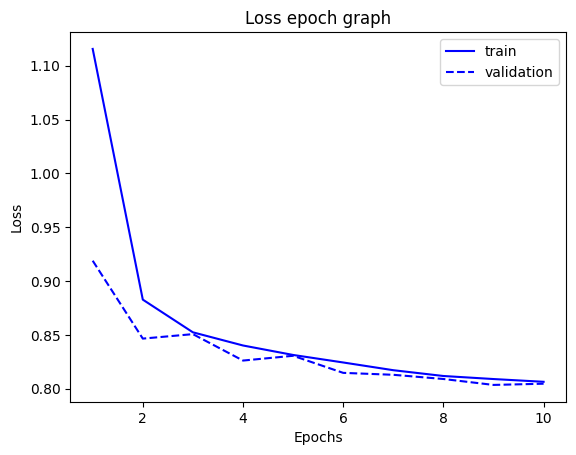

In [ ]:
plt.plot(range(1, len(losses5_cpu["train"])+1), losses5_cpu["train"], label='train', color='b')
plt.plot(range(1, len(losses5_cpu["validation"])+1), losses5_cpu["validation"], label='validation', color='b', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss epoch graph')
plt.legend()

In [ ]:
import pickle

# Save model & data
torch.save(model_soil, 'model_soil.pth')
with open('model_soil_losses.pickle', 'wb') as handle:
    pickle.dump(losses5_cpu, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
submission3_arr = test(test_dataset, model_soil, device, scaler, target_cols) # A seperate model submission if needed

  0%|          | 0/13873 [00:00<?, ?it/s]

In [ ]:
submission3_df = pd.DataFrame(submission3_arr)

display(submission3_df.head())

submission3_df.to_csv('submission3.csv', index=False)

id        X4        X11       X18        X26       X50        X3112
0  195066138  0.436455  20.943061  0.354543   1.184477  1.248427   556.970209
1  195524180  0.459572  20.934779  0.890158   1.793626  1.051395   908.438609
2  172220512  0.561984  14.140450  5.436485  28.144027  1.488253  3476.019017
3  195824490  0.573007  10.364002  1.110598   2.609106  1.720607   408.406202
4  191793047  0.434299  17.207084  0.165987   0.388791  1.346895   281.935198

In [ ]:
submission_ensemble = (submission1_df+submission2_df+submission3_df)/3

In [ ]:
display(submission_ensemble.head())
submission_ensemble.to_csv('submission_combined.csv', index=False)

id        X4        X11       X18        X26       X50  \
0  195066138.0  0.448486  20.313253  0.407618   1.033078  1.230904   
1  195524180.0  0.476977  19.556641  1.285763   3.382973  1.202845   
2  172220512.0  0.567964  13.957158  5.015181  21.578701  1.512871   
3  195824490.0  0.555850  10.972046  1.154265   3.597609  1.681040   
4  191793047.0  0.435787  17.994190  0.259893   0.588520  1.364091   

         X3112  
0   619.161869  
1  1291.760760  
2  3047.648930  
3   471.425675  
4   321.086672

The results from this kaggle submission comes out to be:
![sub1](https://i.ibb.co/ZLNgCf5/res3.png)
The result is way way significantly better than the previous model. This places me at 54th out of 116th for now.<br>
However the R2 loss is still negative, although really close to 0. This means there is a lot of room for improvement still.<br>
Further work could be finding better parameters for our CNN and MLP models, since we don't know if the layers set for the MLP model is optimal.<br>
Additionally, the performance of ensamble methods boosting this dataset significantly says that we should experiement with other such setups in order to maximize performance.

# Bonus Step 6: Ensembling three CNN+MLP models
Instead of using two MLP's and a CNN+MLP model, we can instead have one main CNN which trains on the plant images, then feeds those features down to an MLP model with their numerical data (geolocation, weather, soil).<br>
We also change our CNN model from ResNet50 to the EfficientViT which is apparently the state of the art model for vision based tasks. Two other state of the art CNNs Xception and MobileNetV2 were trained too and the average of the three results were used.<br>
Another change we made is that the loss function we measure is the MSE.

In [ ]:
# dataloader which groups all the three model's data

class DatasetPlants(Dataset):

    def __init__(self, X_df, y, transforms=None):
        self.X_jpeg_bytes = X_df['image'].values
        self.geolocation = torch.tensor(X_df[[col for col in X_df.columns if 'MODIS' in col or 'VOD' in col]].values)
        self.weather = torch.tensor(X_df[[col for col in X_df.columns if 'WORLDCLIM' in col]].values)
        self.soil = torch.tensor(X_df[[col for col in X_df.columns if 'SOIL' in col]].values)
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return len(self.X_jpeg_bytes)

    def __getitem__(self, index):
        X_sample = self.transforms(
            image=imageio.imread(self.X_jpeg_bytes[index]),
        )['image']
        y_sample = self.y[index]

        return X_sample, self.geolocation[index], self.weather[index], self.soil[index], y_sample

In [ ]:
train_set_df, validation_set_df = train_test_split(train_df, test_size=0.1)

In [ ]:
# Prepare output labels

scaler = StandardScaler()

y_train = np.zeros_like(train_set_df[np.array(target_cols)], dtype=np.float32)
y_validation = np.zeros_like(validation_set_df[np.array(target_cols)], dtype=np.float32)
for target_idx, target in enumerate(target_cols):
    v1 = train_set_df[target].values
    v2 = validation_set_df[target].values
    if target != 'X4_mean':
        # Scale to log10 as noted before
        v1 = np.log10(v1)
        v2 = np.log10(v2)
    y_train[:,target_idx] = v1
    y_validation[:,target_idx] = v2

# Apply Scaler
y_train = scaler.fit_transform(y_train)
y_validation = scaler.fit_transform(y_validation)

In [ ]:
# Augmentation

transform_pipe = A.Compose([
    # Randomly flip images
    A.HorizontalFlip(p=0.5),
    # Also crop images and then resize images to 288 x 288 cause that's the input for EfficientVIT
    A.RandomSizedCrop(
      [384, 512],
      288, 288, w2h_ratio=1.0, p=1.0
    ),
    # Also randomly adjust brightness
    A.RandomBrightnessContrast(brightness_limit=0.10, contrast_limit=0.10, p=0.50),
    # Also randomly change the compression
    A.ImageCompression(quality_lower=75, quality_upper=100, p=0.5),
    A.ToFloat(),

    # Normalize the mean and standard dev
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=1
    ),

    # Converts images to tensors
    ToTensorV2(),
])

test_transformation_pipe = A.Compose([
    # Resize image to 288 x 288
    A.Resize(
        288,
        288,
        always_apply = True,
    ),
    A.ToFloat(),

    # Normalize the mean and standard dev
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=1
    ),

    # Converts images to tensors
    ToTensorV2(),
])

In [ ]:
# Train
train_dataset = DatasetPlants(
    train_set_df,
    y_train,
    transform_pipe
)

train_dataloader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
    )

# Validation
validation_dataset = DatasetPlants(
    validation_set_df,
    y_validation,
    transform_pipe
)

validation_dataloader = DataLoader(
        validation_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
)

# Test
test_dataset = DatasetPlants(
    test_df,
    test_df['id'].values,
    test_transformation_pipe
)

In [ ]:
class ModelEfficientVit(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
                'efficientvit_b1.r288_in1k',
                pretrained=True,
                num_classes=0
            )
        self.mlp = nn.Sequential(OrderedDict([
            ('dense1', nn.Linear(419, 800)),
            ('a1', nn.ReLU()),
            ('dense2', nn.Linear(800, 535)),
            ('a2', nn.ReLU()),
            ('dense3', nn.Linear(535, 411)),
            ('a3', nn.ReLU()),
            ('dense4', nn.Linear(411, 123)),
            ('a4', nn.ReLU()),
            ('dense5', nn.Linear(123, 72)),
            ('a5', nn.ReLU()),
            ('dense6', nn.Linear(72, 41)),
            ('a6', nn.ReLU()),
            ('dense7', nn.Linear(41, 25)),
            ('a7', nn.ReLU()),
            ('output', nn.Linear(25, 6)),
        ]))

    def forward(self, inputs_img, inputs_geolocation, inputs_weather, inputs_soil):
      cnn_out = self.backbone(inputs_img)
      merged = torch.cat((cnn_out, inputs_geolocation.float(), inputs_weather.float(), inputs_soil.float()),1)
      return self.mlp(merged)

class ModelXception(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
                'xception71.tf_in1k',
                pretrained=True,
                num_classes=0
            )
        self.mlp = nn.Sequential(OrderedDict([
            ('dense1', nn.Linear(2211, 2500)),
            ('a1', nn.ReLU()),
            ('dense2', nn.Linear(2500, 1988)),
            ('a2', nn.ReLU()),
            ('dense3', nn.Linear(1988, 1515)),
            ('a3', nn.ReLU()),
            ('dense4', nn.Linear(1515, 813)),
            ('a4', nn.ReLU()),
            ('dense5', nn.Linear(813, 541)),
            ('a5', nn.ReLU()),
            ('dense6', nn.Linear(541, 434)),
            ('a6', nn.ReLU()),
            ('dense7', nn.Linear(434, 151)),
            ('a7', nn.ReLU()),
            ('dense8', nn.Linear(151, 75)),
            ('a8', nn.ReLU()),
            ('dense9', nn.Linear(75, 47)),
            ('a9', nn.ReLU()),
            ('dense10', nn.Linear(47, 26)),
            ('a10', nn.ReLU()),
            ('output', nn.Linear(26, 6)),
        ]))

    def forward(self, inputs_img, inputs_geolocation, inputs_weather, inputs_soil):
      cnn_out = self.backbone(inputs_img)
      merged = torch.cat((cnn_out, inputs_geolocation.float(), inputs_weather.float(), inputs_soil.float()),1)
      return self.mlp(merged)

class ModelMobileNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
                'mobilenetv2_100.ra_in1k',
                pretrained=True,
                num_classes=0
            )
        self.mlp = nn.Sequential(OrderedDict([
            ('dense1', nn.Linear(1443, 2000)),
            ('a1', nn.ReLU()),
            ('dense2', nn.Linear(2000, 1732)),
            ('a2', nn.ReLU()),
            ('dense3', nn.Linear(1732, 991)),
            ('a3', nn.ReLU()),
            ('dense4', nn.Linear(991, 674)),
            ('a4', nn.ReLU()),
            ('dense5', nn.Linear(674, 555)),
            ('a5', nn.ReLU()),
            ('dense6', nn.Linear(555, 177)),
            ('a6', nn.ReLU()),
            ('dense7', nn.Linear(177, 81)),
            ('a7', nn.ReLU()),
            ('dense8', nn.Linear(81, 53)),
            ('a8', nn.ReLU()),
            ('dense9', nn.Linear(53, 27)),
            ('a9', nn.ReLU()),
            ('output', nn.Linear(27, 6)),
        ]))

    def forward(self, inputs_img, inputs_geolocation, inputs_weather, inputs_soil):
      cnn_out = self.backbone(inputs_img)
      merged = torch.cat((cnn_out, inputs_geolocation.float(), inputs_weather.float(), inputs_soil.float()),1)
      return self.mlp(merged)

In [ ]:
# Setup a learning scheduler

def make_scheduler(optimizer):
  return torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=3e-4,
        total_steps=len(y_validation) // 32 * 10 + len(y_train) // 32 * 10 + 2,
        pct_start=0.10,
        anneal_strategy='cos',
        div_factor=1e3,
        final_div_factor=1e4,
    )

In [ ]:
model_vit = ModelEfficientVit()
optimizer = torch.optim.AdamW(
    params=model_vit.parameters(),
    lr=3e-4,
    weight_decay=0.01,
)
loss_fn = nn.L1Loss()
scheduler = make_scheduler(optimizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/36.5M [00:00<?, ?B/s]

In [ ]:
def print_time(start, end):
    total_time = end - start
    print(f"Time taken: {total_time:.3f} seconds")
    return total_time

In [ ]:
# Our train function

def train(dataloaders, y_labels, model, device, epochs, optimizer, loss_fn, scheduler, print_at):
  losses = {"train": [], "validation": []}
  start_time = timer()
  model = model.to(device)
  y_train_mean = torch.tensor(y_labels["train"]).mean(dim=0).to(device)
  y_validation_mean = torch.tensor(y_labels["validation"]).mean(dim=0).to(device)
  for i in range(epochs):
    for phase in ["train", "validation"]:
      epoch_err_total = 0.0
      count = 0
      if phase == "train":
        model.train()
      else:
        model.eval()

      for j, (X_img, X_geolocation, X_weather, X_soil, labels) in enumerate(dataloaders[phase]):
        X_img = X_img.to(device)
        X_geolocation = X_geolocation.to(device)
        X_weather = X_weather.to(device)
        X_soil = X_soil.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == "train"):
          y = model(X_img, X_geolocation, X_weather, X_soil)

          loss = loss_fn(y, labels)

          epoch_err_total += loss.sum()
          count += loss.numel()
          if phase == "train":
            loss.backward()
            optimizer.step()

          scheduler.step()
          if (j % print_at) == (print_at-1) and phase == "train":
            print(f"epoch: {i+1}, step: {j+1} = loss: {epoch_err_total/count}")

      # Print epoch stats
      print(f"epoch: {i+1} = {phase} loss: {epoch_err_total/count}")
      losses[phase].append(epoch_err_total/count)
  end_time = timer()
  print_time(start_time, end_time)
  return losses

In [ ]:
losses_vit = train({"train": train_dataloader, "validation": validation_dataloader}, {"train": y_train, "validation": y_validation}, model_vit, device, 10, optimizer, loss_fn, scheduler, 50)

epoch: 1, step: 50 = loss: 0.8181948065757751
epoch: 1, step: 100 = loss: 0.7948203086853027
epoch: 1, step: 150 = loss: 0.7804239988327026
epoch: 1, step: 200 = loss: 0.7658745646476746
epoch: 1, step: 250 = loss: 0.7587580680847168
epoch: 1, step: 300 = loss: 0.7496850490570068
epoch: 1, step: 350 = loss: 0.7449365854263306
epoch: 1, step: 400 = loss: 0.7383303642272949
epoch: 1, step: 450 = loss: 0.7330791354179382
epoch: 1, step: 500 = loss: 0.727440595626831
epoch: 1, step: 550 = loss: 0.721134603023529
epoch: 1, step: 600 = loss: 0.7152218818664551
epoch: 1, step: 650 = loss: 0.7108733654022217
epoch: 1, step: 700 = loss: 0.706123948097229
epoch: 1, step: 750 = loss: 0.7011334300041199
epoch: 1, step: 800 = loss: 0.6976463794708252
epoch: 1, step: 850 = loss: 0.6947092413902283
epoch: 1, step: 900 = loss: 0.691070020198822
epoch: 1, step: 950 = loss: 0.6884689331054688
epoch: 1, step: 1000 = loss: 0.6863419413566589
epoch: 1, step: 1050 = loss: 0.6832566857337952
epoch: 1, step: 

In [ ]:
losses_vit_cpu = {}

for a in losses_vit:
  losses_vit_cpu[a] = []
  for b in losses_vit[a]:
    losses_vit_cpu[a].append(b.detach().cpu().item())

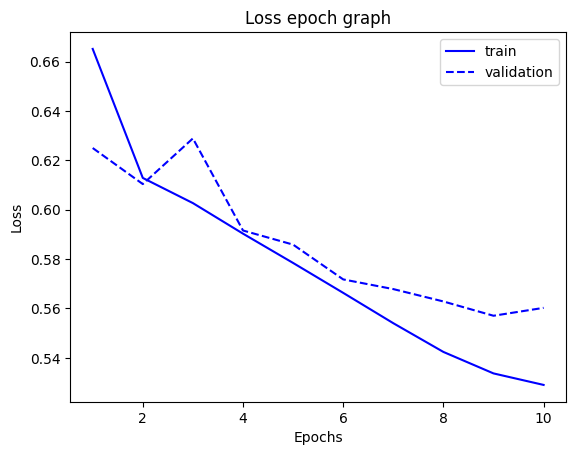

In [ ]:
plt.plot(range(1, len(losses_vit_cpu["train"])+1), losses_vit_cpu["train"], label='train', color='b')
plt.plot(range(1, len(losses_vit_cpu["validation"])+1), losses_vit_cpu["validation"], label='validation', color='b', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss epoch graph')
plt.legend()

In [ ]:
import pickle

# Save model & data
torch.save(model_vit, 'model_vit.pth')
with open('model_vit_losses.pickle', 'wb') as handle:
    pickle.dump(losses_vit_cpu, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Our test function -- To get results, we have to submit to kaggle since they have not provided test values

def test(test_dataset, model, device, scaler, target_cols):
  submission = []

  # Important to put model into test mode -- since layers like dropout etc differs between training and testing
  model.eval()
  for X_sample_test, X_geolocation, X_weather, X_soil, test_id in tqdm(test_dataset):
    with torch.no_grad():
      const = torch.tensor(3)
      y_pred = model(X_sample_test.unsqueeze(0).to(device), X_geolocation.unsqueeze(0).to(device), X_weather.unsqueeze(0).to(device), X_soil.unsqueeze(0).to(device)).detach().cpu().numpy()
      # Reverse Scaling
      y_pred = scaler.inverse_transform(y_pred).squeeze()

      row = {'id': test_id }
      for k, v in zip(target_cols, y_pred):
        # Remove "_mean" part of target column
        if k != 'X4_mean':
            row[k.replace('_mean', '')] = 10 ** v
        else:
            row[k.replace('_mean', '')] = v

      submission.append(row)
  return submission

In [ ]:
submission_vit_arr = test(test_dataset, model_vit, device, scaler, target_cols) # A seperate model submission if needed

  0%|          | 0/13873 [00:00<?, ?it/s]

In [ ]:
submission_vit = pd.DataFrame(submission_vit_arr)
display(submission_vit.head())
submission_vit.to_csv('submission_vit.csv', index=False)

id        X4        X11       X18        X26       X50        X3112
0  195066138  0.445696  19.868320  0.558252   3.001838  1.272534  1411.783540
1  195524180  0.567341   8.458253  4.441665   6.623016  1.767677   295.318829
2  172220512  0.566205  14.129819  5.859485  34.193151  1.539518  3606.930114
3  195824490  0.612993   8.818973  2.170137   9.153028  2.019119   536.289389
4  191793047  0.366462  21.868438  0.300615   1.609961  1.272250  1417.269827

In [ ]:
# Augmentation

transform_pipe = A.Compose([
    # Randomly flip images
    A.HorizontalFlip(p=0.5),
    # Also crop images and then resize images to 299 x 299 cause that's the input for Xception
    A.RandomSizedCrop(
      [384, 512],
      299, 299, w2h_ratio=1.0, p=1.0
    ),
    # Also randomly adjust brightness
    A.RandomBrightnessContrast(brightness_limit=0.10, contrast_limit=0.10, p=0.50),
    # Also randomly change the compression
    A.ImageCompression(quality_lower=75, quality_upper=100, p=0.5),
    A.ToFloat(),

    # Normalize the mean and standard dev
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=1
    ),

    # Converts images to tensors
    ToTensorV2(),
])

test_transformation_pipe = A.Compose([
    # Resize image to 299 x 299
    A.Resize(
        299,
        299,
        always_apply = True,
    ),
    A.ToFloat(),

    # Normalize the mean and standard dev
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=1
    ),

    # Converts images to tensors
    ToTensorV2(),
])

In [ ]:
# Train
train_dataset = DatasetPlants(
    train_set_df,
    y_train,
    transform_pipe
)

train_dataloader = DataLoader(
        train_dataset,
        batch_size=16,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
    )

# Validation
validation_dataset = DatasetPlants(
    validation_set_df,
    y_validation,
    transform_pipe
)

validation_dataloader = DataLoader(
        validation_dataset,
        batch_size=16,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
)

# Test
test_dataset = DatasetPlants(
    test_df,
    test_df['id'].values,
    test_transformation_pipe
)

In [ ]:
# Setup a learning scheduler

def make_scheduler(optimizer):
  return torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=3e-4,
        total_steps=len(y_validation) // 16 * 5 + len(y_train) // 16 * 5 + 5,
        pct_start=0.10,
        anneal_strategy='cos',
        div_factor=1e3,
        final_div_factor=1e4,
    )

In [ ]:
model_xcept = ModelXception()
optimizer = torch.optim.AdamW(
    params=model_xcept.parameters(),
    lr=3e-4,
    weight_decay=0.01,
)
loss_fn = nn.L1Loss()
scheduler = make_scheduler(optimizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/170M [00:00<?, ?B/s]

In [ ]:
losses_xcept = train({"train": train_dataloader, "validation": validation_dataloader}, {"train": y_train, "validation": y_validation}, model_xcept, device, 5, optimizer, loss_fn, scheduler, 50)

epoch: 1, step: 50 = loss: 0.7407563328742981
epoch: 1, step: 100 = loss: 0.742045521736145
epoch: 1, step: 150 = loss: 0.7469657063484192
epoch: 1, step: 200 = loss: 0.7389797568321228
epoch: 1, step: 250 = loss: 0.7366164326667786
epoch: 1, step: 300 = loss: 0.7328755855560303
epoch: 1, step: 350 = loss: 0.7302605509757996
epoch: 1, step: 400 = loss: 0.7309936285018921
epoch: 1, step: 450 = loss: 0.7274119257926941
epoch: 1, step: 500 = loss: 0.7230404615402222
epoch: 1, step: 550 = loss: 0.717803955078125
epoch: 1, step: 600 = loss: 0.7138155102729797
epoch: 1, step: 650 = loss: 0.7102264165878296
epoch: 1, step: 700 = loss: 0.7085549235343933
epoch: 1, step: 750 = loss: 0.7068037986755371
epoch: 1, step: 800 = loss: 0.7048667073249817
epoch: 1, step: 850 = loss: 0.7017949223518372
epoch: 1, step: 900 = loss: 0.6987903118133545
epoch: 1, step: 950 = loss: 0.696850061416626
epoch: 1, step: 1000 = loss: 0.6958982944488525
epoch: 1, step: 1050 = loss: 0.6939082741737366
epoch: 1, step:

In [ ]:
losses_xcept_cpu = {}

for a in losses_xcept:
  losses_xcept_cpu[a] = []
  for b in losses_xcept[a]:
    losses_xcept_cpu[a].append(b.detach().cpu().item())

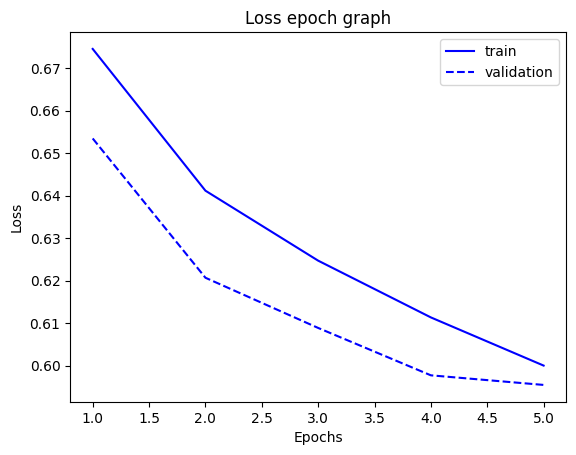

In [ ]:
plt.plot(range(1, len(losses_xcept_cpu["train"])+1), losses_xcept_cpu["train"], label='train', color='b')
plt.plot(range(1, len(losses_xcept_cpu["validation"])+1), losses_xcept_cpu["validation"], label='validation', color='b', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss epoch graph')
plt.legend()

In [ ]:
import pickle

# Save model & data
torch.save(model_xcept, 'model_xcept.pth')
with open('model_xcept_losses.pickle', 'wb') as handle:
    pickle.dump(losses_xcept_cpu, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
submission_xcept_arr = test(test_dataset, model_xcept, device, scaler, target_cols) # A seperate model submission if needed

  0%|          | 0/13873 [00:00<?, ?it/s]

In [ ]:
submission_xcept = pd.DataFrame(submission_xcept_arr)
display(submission_xcept.head())
submission_xcept.to_csv('submission_xcept.csv', index=False)

id        X4        X11       X18        X26       X50        X3112
0  195066138  0.442514  19.658521  0.452036   1.197855  1.193466   752.057388
1  195524180  0.483374  19.871740  1.106160   3.626023  1.069071  1924.916553
2  172220512  0.552840  14.604518  4.535428  19.002578  1.476761  2575.983230
3  195824490  0.489434  14.601737  0.495666   1.537959  1.565101   450.506753
4  191793047  0.416924  17.458369  0.187649   0.644406  1.399496   341.358901

In [ ]:
# Augmentation

transform_pipe = A.Compose([
    # Randomly flip images
    A.HorizontalFlip(p=0.5),
    # Also crop images and then resize images to 224 x 224 cause that's the input for MobileNet
    A.RandomSizedCrop(
      [384, 512],
      224, 224, w2h_ratio=1.0, p=1.0
    ),
    # Also randomly adjust brightness
    A.RandomBrightnessContrast(brightness_limit=0.10, contrast_limit=0.10, p=0.50),
    # Also randomly change the compression
    A.ImageCompression(quality_lower=75, quality_upper=100, p=0.5),
    A.ToFloat(),

    # Normalize the mean and standard dev
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=1
    ),

    # Converts images to tensors
    ToTensorV2(),
])

test_transformation_pipe = A.Compose([
    # Resize image to 224 x 224
    A.Resize(
        224,
        224,
        always_apply = True,
    ),
    A.ToFloat(),

    # Normalize the mean and standard dev
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=1
    ),

    # Converts images to tensors
    ToTensorV2(),
])

In [ ]:
# Train
train_dataset = DatasetPlants(
    train_set_df,
    y_train,
    transform_pipe
)

train_dataloader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
    )

# Validation
validation_dataset = DatasetPlants(
    validation_set_df,
    y_validation,
    transform_pipe
)

validation_dataloader = DataLoader(
        validation_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
)

# Test
test_dataset = DatasetPlants(
    test_df,
    test_df['id'].values,
    test_transformation_pipe
)

In [ ]:
model_mobile = ModelMobileNet()
optimizer = torch.optim.AdamW(
    params=model_mobile.parameters(),
    lr=3e-4,
    weight_decay=0.01,
)
loss_fn = nn.L1Loss()
scheduler = make_scheduler(optimizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

In [ ]:
losses_mobile = train({"train": train_dataloader, "validation": validation_dataloader}, {"train": y_train, "validation": y_validation}, model_mobile, device, 10, optimizer, loss_fn, scheduler, 50)

epoch: 1, step: 50 = loss: 0.7593918442726135
epoch: 1, step: 100 = loss: 0.7442797422409058
epoch: 1, step: 150 = loss: 0.7393656969070435
epoch: 1, step: 200 = loss: 0.7396221160888672
epoch: 1, step: 250 = loss: 0.7342377305030823
epoch: 1, step: 300 = loss: 0.7293174862861633
epoch: 1, step: 350 = loss: 0.7253873944282532
epoch: 1, step: 400 = loss: 0.7240312099456787
epoch: 1, step: 450 = loss: 0.720272958278656
epoch: 1, step: 500 = loss: 0.7171118259429932
epoch: 1, step: 550 = loss: 0.713283896446228
epoch: 1, step: 600 = loss: 0.710175096988678
epoch: 1, step: 650 = loss: 0.706311047077179
epoch: 1, step: 700 = loss: 0.7047489881515503
epoch: 1, step: 750 = loss: 0.700465977191925
epoch: 1, step: 800 = loss: 0.6984642744064331
epoch: 1, step: 850 = loss: 0.695711076259613
epoch: 1, step: 900 = loss: 0.6929459571838379
epoch: 1, step: 950 = loss: 0.6909952759742737
epoch: 1, step: 1000 = loss: 0.6892934441566467
epoch: 1, step: 1050 = loss: 0.6875412464141846
epoch: 1, step: 11

In [ ]:
losses_mobile_cpu = {}

for a in losses_mobile:
  losses_mobile_cpu[a] = []
  for b in losses_mobile[a]:
    losses_mobile_cpu[a].append(b.detach().cpu().item())

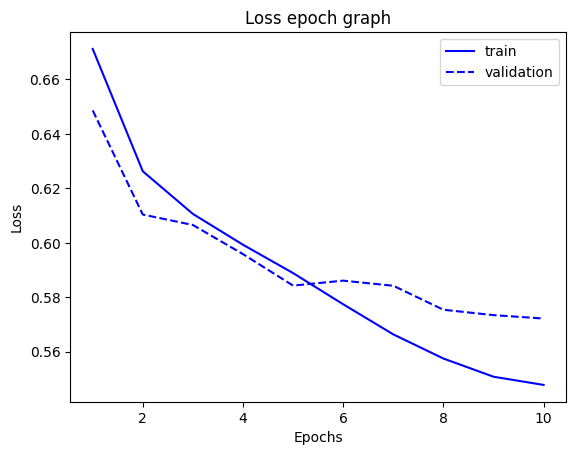

In [ ]:
plt.plot(range(1, len(losses_mobile_cpu["train"])+1), losses_mobile_cpu["train"], label='train', color='b')
plt.plot(range(1, len(losses_mobile_cpu["validation"])+1), losses_mobile_cpu["validation"], label='validation', color='b', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss epoch graph')
plt.legend()

In [ ]:
import pickle

# Save model & data
torch.save(model_mobile, 'model_mobile.pth')
with open('model_mobile_losses.pickle', 'wb') as handle:
    pickle.dump(losses_mobile_cpu, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
submission_mobile_arr = test(test_dataset, model_mobile, device, scaler, target_cols) # A seperate model submission if needed

  0%|          | 0/13873 [00:00<?, ?it/s]

In [ ]:
submission_mobile = pd.DataFrame(submission_mobile_arr)
display(submission_mobile.head())
submission_mobile.to_csv('submission_mobile.csv', index=False)

id        X4        X11       X18        X26       X50        X3112
0  195066138  0.488535  18.380238  1.061620   4.724606  1.368505  1775.504180
1  195524180  0.536228  13.372892  2.093495   4.278251  1.411160   964.509643
2  172220512  0.580278  13.270004  9.493493  71.085049  1.590253  4403.017678
3  195824490  0.690356   7.568617  5.597647  13.964258  2.114808  1295.047961
4  191793047  0.431439  18.561466  0.260554   1.071628  1.402877   528.045988

In [ ]:
submission_vit = pd.read_csv('submission_vit.csv')
submission_xcept = pd.read_csv('submission_xcept.csv')
submission_mobile = pd.read_csv('submission_mobile.csv')
submission_ensemble = (submission_vit + submission_xcept + submission_mobile) / 3

In [ ]:
display(submission_ensemble.head())
submission_mobile.to_csv('submission_ensemble.csv', index=False)

id        X4        X11       X18        X26       X50  \
0  195066138.0  0.458915  19.302360  0.690636   2.974767  1.278168   
1  195524180.0  0.528981  13.900962  2.547106   4.842430  1.415969   
2  172220512.0  0.566441  14.001447  6.629469  41.426926  1.535511   
3  195824490.0  0.597594  10.329775  2.754483   8.218415  1.899676   
4  191793047.0  0.404942  19.296091  0.249606   1.108665  1.358208   

         X3112  
0  1313.115036  
1  1061.581675  
2  3528.643674  
3   760.614701  
4   762.224905

![resens](https://i.ibb.co/x7vJXGH/Screenshot-from-2024-03-08-21-52-28.png)

Here the result seems to have not improved much. The gist is that maybe we need run it for longer, i.e., more epochs in order for it to converge better or understand the domain problem better.
